In [1]:
import tensorflow as tf

In [2]:
import numpy as np

In [3]:
import pandas as pd

In [4]:
import mne

In [5]:
import os

In [6]:
import keras

Using TensorFlow backend.


In [7]:
import seaborn as sns

In [8]:
from collections import Counter

In [9]:
from tqdm import tqdm_notebook
from tqdm import tqdm_notebook as tqdm

In [10]:
import matplotlib.pyplot as plt

Какие каналы содержат 

Dataset:
- Один сэмпл содержит чанк сигнала, чанки не пересекаются
- Считывание происходит из случайных файлов из списка
- Чанки рандомизированы:
    - Учесть рандомизацию по номеру пациента, сессии, времени

# Read labels

In [11]:
header = ["file", "start", "end", "label", "confidence"]
train_df = pd.read_csv("../_DOCS/ref_train.txt", sep=" ", names=header)
val_df = pd.read_csv("../_DOCS/ref_dev.txt", sep=" ", names=header)

In [12]:
def preprocess_file(full_file):
    parts = full_file.split("_")
    patient = int(parts[0])
    session = int(parts[1][1:])
    file = int(parts[2][1:])
    return [patient, session, file]

In [13]:
preprocess_file("00000258_s002_t000")

[258, 2, 0]

In [14]:
def append_file_info(df):
    values = np.array(df["file"].apply(preprocess_file).tolist())
    files_df = pd.DataFrame(values, columns=["patient", "session", "chunk"], index=df.index)
    return df.merge(files_df, how="inner", left_index=True, right_index=True)

In [15]:
train_df = append_file_info(train_df)

In [16]:
val_df = append_file_info(val_df)

# Attach files

TODO add other electrode formats

In [17]:
def attach_files(df, dataset):
    paths = {}

    for root, dirs, files in os.walk("../edf/{}".format(dataset)):
        path = root.split(os.sep)
        for file in files:
            if ".edf" in file:
                name = file.split(".")[0]
                paths[name] = os.path.abspath(root) + "/" +  file
    
    df["full_path"] = df["file"].apply(paths.get)
    df = df[df["full_path"].apply(lambda x: "01_tcp_ar" in str(x))].copy()
    return df

In [18]:
train_df = attach_files(train_df, "train")

In [19]:
val_df = attach_files(val_df, "dev")

# Separate patients

In [20]:
train_patients = train_df["patient"].unique() 

In [21]:
val_patients = val_df["patient"].unique()

In [22]:
val_df = val_df[~val_df["patient"].isin(train_patients)].copy()

# Remove bckg files

In [23]:
def remove_bckg_files(df):
    files_with_seizures = df[df["label"] == "seiz"]["file"].unique()
    return df[df["file"].isin(files_with_seizures)].copy()

In [24]:
train_df = remove_bckg_files(train_df)

In [25]:
val_df = remove_bckg_files(val_df)

# Calculate channels intersection and proper sample rate

In [26]:
def get_edf_info(df):
    files = df["full_path"].unique()

    edf_data = []

    for file in tqdm_notebook(files):
        edf = mne.io.read_raw_edf(file, verbose="ERROR")
        data = {
            field: edf.info[field]
            for field in ["ch_names", "sfreq"]
        }
        edf_data.append(data)
        
    return pd.DataFrame(edf_data)

In [27]:
train_edf_df = get_edf_info(train_df)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [28]:
val_edf_df = get_edf_info(val_df)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [29]:
CHUNK_FREQUENCY = int(min(train_edf_df["sfreq"].min(), val_edf_df["sfreq"].min()))

In [30]:
counter = Counter([
    channel for channels_list in train_edf_df["ch_names"] for channel in channels_list
] + [
    channel for channels_list in val_edf_df["ch_names"] for channel in channels_list
])

In [31]:
all_channels = dict(counter.most_common())

In [32]:
usage_limit = max([v for k, v in all_channels.items() if "STI" not in k])
CHANNELS = [k for k, v in all_channels.items() if v >= usage_limit and "STI" not in k]

In [33]:
# STIM_CHANNEL = [k for k in all_channels.keys() if "STI" in k][0]

In [34]:
len(CHANNELS)

21

In [35]:
CHANNELS_MAPPING = [
    ("EEG FP1-REF", "EEG F7-REF"), 
    ("EEG F7-REF", "EEG T3-REF"), 
    ("EEG T3-REF", "EEG T5-REF"), 
    ("EEG T5-REF", "EEG O1-REF"), 
    ("EEG FP2-REF", "EEG F8-REF"), 
    ("EEG F8-REF", "EEG T4-REF"), 
    ("EEG T4-REF", "EEG T6-REF"), 
    ("EEG T6-REF", "EEG O2-REF"), 
    ("EEG A1-REF", "EEG T3-REF"), 
    ("EEG T3-REF", "EEG C3-REF"), 
    ("EEG C3-REF", "EEG CZ-REF"), 
    ("EEG CZ-REF", "EEG C4-REF"), 
    ("EEG C4-REF", "EEG T4-REF"), 
    ("EEG T4-REF", "EEG A2-REF"), 
    ("EEG FP1-REF", "EEG F3-REF"), 
    ("EEG F3-REF", "EEG C3-REF"), 
    ("EEG C3-REF", "EEG P3-REF"), 
    ("EEG P3-REF", "EEG O1-REF"), 
    ("EEG FP2-REF", "EEG F4-REF"), 
    ("EEG F4-REF", "EEG C4-REF"), 
    ("EEG C4-REF", "EEG P4-REF"), 
    ("EEG P4-REF", "EEG O2-REF")
]

CHANNELS_MAPPING = [c for c in CHANNELS_MAPPING if (c[0] in CHANNELS) and (c[1] in CHANNELS)]

CHANNELS_MAPPING_1 = [c[0] for c in CHANNELS_MAPPING]
CHANNELS_MAPPING_2 = [c[1] for c in CHANNELS_MAPPING]

# Calculate chunk size

In [36]:
train_df["duration"] = train_df["end"] - train_df["start"]

label
bckg    AxesSubplot(0.125,0.125;0.775x0.755)
seiz    AxesSubplot(0.125,0.125;0.775x0.755)
Name: duration, dtype: object

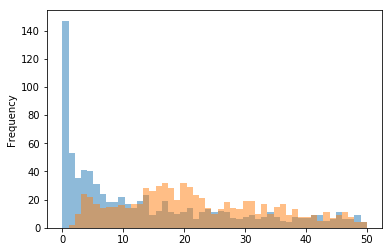

In [37]:
train_df.groupby('label')["duration"].plot(kind="hist", bins=np.linspace(0, 50), alpha=0.5)

In [38]:
CHUNK_TIME = 1 * CHUNK_FREQUENCY # number of terms per chunk

# Split on chunks

In [39]:
BATCH_SIZE = 32

- Get all file names, randomize them
- For each file - split on chunks, randomize them
- Get labels for each chunk

In [40]:
FFT_STEPS_NUM = 125

TODO:
- Fourier transform for chunk instead of full file

Как западить чанку нулями, и убрать их из лосса? Варианты:

### Удалять пустые чанки
3. Заменить в массиве data и events неполные чанки на зануленные
4. Добавить параметр mask, который отвечает за то, какие элементы функции потерь оставить
5. Заменить лосс


In [41]:
MAX_LENGTH = 300000

In [42]:
# def get_fourier_transform(data, window_size=CHUNK_TIME, step_size=CHUNK_TIME // FFT_STEPS_NUM):
#     frequencies = []
#     for window in range(0, data.shape[0] - window_size, step_size):
#         chunk = data[window:window + window_size]
#         frequency_values = np.abs(np.fft.fft(chunk, axis=0))[:window_size // 2]
#         frequencies.append(frequency_values)
#     result = np.stack(frequencies)
#     return result

In [43]:
def get_data(df, file, channels=CHANNELS, chunk_size=CHUNK_TIME):
    annotations = df[
        (df["full_path"] == file) & \
        (df["label"] == "seiz")
    ][["start", "end"]]
    edf = mne.io.read_raw_edf(file, preload=True, verbose='ERROR')
    edf.filter(2, 60)
    edf_picks = edf.pick_channels(channels)
    data, time = edf_picks[:]
        
    events = time * 0
    for _, (start, end) in annotations.iterrows():
        events += (time >= start) & (time <= end)
    events = (events > 0).astype(int)
    
    del edf
    
    return data, events

In [44]:
def get_data_multiple(df, files, channels=CHANNELS, chunk_size=CHUNK_TIME):
    total_data = []
    total_events = []
    for file in tqdm_notebook(files):
        data, events = get_data(df, file)
        total_data.append(data)
        total_events.append(events)
    
    return total_data, total_events

In [ ]:
# stft(artificial_signal, fs=CHUNK_TIME, window="hann", nperseg=window_size, noverlap=window_size - step_size, return_onesided=True, boundary=None)

In [45]:
class ChunksIterator():
    def __init__(self, data, events, chunk_size=CHUNK_TIME, step_size=CHUNK_TIME // FFT_STEPS_NUM, max_length=MAX_LENGTH, tqdm_enabled=False):
        self.data = data
        self.events = events
        self.chunk_size = chunk_size
        self.step_size = step_size
        self.valid_chunks = 0
        
        max_time = min(max([e.shape[0] for e in events]), max_length)
        self.iterations = range(0, max_time - 2*chunk_size, chunk_size)
        self.iterations = np.random.choice(self.iterations, len(self.iterations), replace=False)
        self.iterations_number = len(self.iterations)
        if tqdm_enabled:
            self.iterations = tqdm(self.iterations)
        self.iterations = iter(self.iterations)
    
    def __iter__(self):
        return self
    
    def __next__(self):
        data = self.data
        events = self.events
        chunk_size = self.chunk_size
        step_size = self.step_size
        chunk_start = next(self.iterations)
        
        data_chunk = [d[:, chunk_start:chunk_start + 2*chunk_size].T for d in data]
        labels_chunk = [e[chunk_start:chunk_start + chunk_size] for e in events]

        zero_data_chunk = np.zeros((chunk_size * 2, len(CHANNELS)))
        zero_labels_chunk = np.zeros((chunk_size, ))

        masks_chunk = [e.shape[0] == chunk_size for e in labels_chunk]
        data_chunk = [d if d.shape[0] == 2*chunk_size else zero_data_chunk for d in data_chunk]
        labels_chunk = [e if e.shape[0] == chunk_size else zero_labels_chunk for e in labels_chunk]

        data_chunk = [get_fourier_transform(d) for d in data_chunk]
        labels_chunk = [e.max() for e in labels_chunk]
        
        self.valid_chunks += sum(masks_chunk)

        return np.stack(data_chunk).reshape(len(data_chunk), -1), np.stack(labels_chunk)[:, np.newaxis], np.array(masks_chunk)

In [46]:
def iterate_files(df, batch_size=BATCH_SIZE):
    files = df["full_path"].unique()
    files = np.random.choice(files, len(files), replace=False)
    for files in zip(*[iter(files)]*batch_size):
        yield files

In [47]:
files = next(iterate_files(train_df))

In [48]:
data, events = get_data(train_df, files[0])

In [49]:
data.shape

(21, 562250)

In [50]:
files = train_df["full_path"].value_counts().index[0:BATCH_SIZE]
data, events = get_data_multiple(train_df, files)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [51]:
partial_lengths = [int(d.shape[1] * 0.005) for d in data]
partial_data = [d[:, :l] for d, l in zip(data, partial_lengths)]
partial_events = [e[:l] for e, l in zip(events, partial_lengths)]
min(partial_lengths)

384

In [52]:
iterator = ChunksIterator(partial_data, partial_events, tqdm_enabled=True)

print("Total iterations:", iterator.iterations_number)

for i, (data_chunk, labels_chunk, masks_chunk) in zip(range(10), iterator):
    print("Iteration {}".format(i), sum(masks_chunk))
    
print("Valid chunks:", iterator.valid_chunks)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Total iterations: 48
Iteration 0 1
Iteration 1 1
Iteration 2 5
Iteration 3 1
Iteration 4 27
Iteration 5 2
Iteration 6 2
Iteration 7 28
Iteration 8 3
Iteration 9 1
Valid chunks: 71


In [53]:
data_chunk.shape

(32, 328125)

# Model creation

In [84]:
NUM_EPOCHS = 10

In [85]:
import tensorflow as tf
from keras.layers import Dense,Activation,Dropout, Input, Conv1D, MaxPool1D, Flatten
from keras.layers import LSTM,Bidirectional,TimeDistributed #could try TimeDistributed(Dense(...))
from keras.models import Sequential, load_model
from keras import optimizers,regularizers
from keras.layers.normalization import BatchNormalization
import keras.backend.tensorflow_backend as KTF

In [86]:
eeg_input = Input(shape=(FFT_STEPS_NUM * CHUNK_TIME // 2 * len(CHANNELS), ))

feature_extractor = eeg_input

x = Dense(100, activation='relu')(feature_extractor)
x = Dense(100, activation='relu')(x)
x = Dense(100, activation='relu')(x)
events_output = Dense(1, activation='sigmoid')(x)

In [87]:
model = keras.models.Model(inputs=[eeg_input], outputs=[events_output])

In [88]:
s = tf.Session()

In [89]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [90]:
model.compile(
    loss="binary_crossentropy",
    optimizer='adam', 
    metrics=['accuracy', recall_m, precision_m]
)

# TODO Try to filter incomplete chunks

# Overfit on small dataset

TODO make model converge on this batch

In [73]:
generator = ChunksIterator(data, events)

In [74]:
for i in range(5):
    next(generator)
x_in, y_end, masks_in = next(generator)

In [75]:
y_end.sum() / (y_end > -1).sum()

0.25

In [76]:
model.predict(x_in).mean()

0.49999195

In [77]:
y_end.shape

(32, 1)

In [78]:
x_in.shape

(32, 328125)

In [79]:
model.evaluate(x_in, y_end)

32/32 [==============================] - 2s 49ms/step


[0.6931304931640625, 0.6875, 0.625, 0.4166666567325592]

In [91]:
# model.fit(x_in, y_end, batch_size=x_in.shape[0], epochs=1000, sample_weight=masks_in)

In [ ]:
y_end.sum()

RNN использовать можно и даже немного нужно
А вот seq2seq не надо - у вас же одинаковая длина входа и выхода. Имплементация будет очень похожа не языковую модельку, как была в последней домашке.

Если это исследования, а не в прод катить, я бы попробовал LMU и LSTM-SHA из реккурентных и Sparse Transformer

# Train model

In [92]:
GENERATOR_PAD_BUG = 1

In [93]:
total_train_history = {}
total_val_history = {}

for epoch in tqdm(range(10)):
    total_train_history[epoch] = []
    total_val_history[epoch] = []
    
    total_train_loss = 0
    total_train_chunks = 0
    
    total_val_loss = 0
    total_val_chunks = 0
    
    for train_files, val_files in tqdm_notebook(list(zip(iterate_files(train_df), iterate_files(val_df)))):
        # Training
        
        train_data, train_events = get_data_multiple(train_df, train_files)
        train_generator = ChunksIterator(train_data, train_events, tqdm_enabled=True)
        
        train_chunks = train_generator.iterations_number
        
        train_history = model.fit_generator(
            train_generator, 
            epochs=1, 
            steps_per_epoch=train_chunks - GENERATOR_PAD_BUG,
            class_weight=[1, 10]
#             pickle_safe=False
        )
        
        total_train_loss += train_history.history['loss'][0] * train_generator.valid_chunks
        total_train_chunks += train_generator.valid_chunks
        
        model.reset_states()
        
        del train_generator
        del train_data
        del train_events
        
        # Validation
        
        val_data, val_events = get_data_multiple(val_df, val_files)
        val_generator = ChunksIterator(val_data, val_events, tqdm_enabled=True)
        
        val_chunks = val_generator.iterations_number
        
        val_metrics = model.evaluate_generator(
            val_generator,
            steps=val_chunks - GENERATOR_PAD_BUG
#             pickle_safe=False
        )
        
        print(val_metrics)
        
        total_val_loss += val_metrics[0] * val_generator.valid_chunks
        total_val_chunks += val_generator.valid_chunks
        
        model.reset_states()
        del val_generator
        del val_data
        del val_events
        
        total_train_history[epoch].append(total_train_loss / total_train_chunks)
        total_val_history[epoch].append(total_val_loss / total_val_chunks)
        
        print("Train loss:", total_train_history)
        print("Val loss:", total_val_history)
    
        model.save_weights("./models/cnn-lstm-fft-model-{}.h5".format(epoch))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Epoch 1/1
1197/1197 [==============================] - 760s 635ms/step - loss: 0.3031 - acc: 0.9164 - recall_m: 0.4565 - precision_m: 0.7344



[2.1448803622596144, 0.794016290726817, 0.23791376340110398, 0.24938406925975232]

Train loss: {0: [0.30305424633567396]}
Val loss: {0: [2.1448803622596144]}


Epoch 1/1
1197/1197 [==============================] - 782s 653ms/step - loss: 0.3589 - acc: 0.9258 - recall_m: 0.7386 - precision_m: 0.8616



[1.0544203843115365, 0.758171470342523, 0.40603849519613694, 0.2918493631097458]

Train loss: {0: [0.30305424633567396, 0.32929468138325574]}
Val loss: {0: [2.1448803622596144, 1.5834509924575548]}


Epoch 1/1
1197/1197 [==============================] - 977s 816ms/step - loss: 0.2793 - acc: 0.9491 - recall_m: 0.7715 - precision_m: 0.8839



[1.8396472828205965, 0.7400532581453634, 0.5142522324421253, 0.3470053148822378]

Train loss: {0: [0.30305424633567396, 0.32929468138325574, 0.31428835473184363]}
Val loss: {0: [2.1448803622596144, 1.5834509924575548, 1.6714587216102568]}


Epoch 1/1
1197/1197 [==============================] - 981s 820ms/step - loss: 0.5591 - acc: 0.9250 - recall_m: 0.7284 - precision_m: 0.8346



[1.4391831275116131, 0.7675960735171261, 0.5649478700176914, 0.4308030485061177]

Train loss: {0: [0.30305424633567396, 0.32929468138325574, 0.31428835473184363, 0.37570128519147755]}
Val loss: {0: [2.1448803622596144, 1.5834509924575548, 1.6714587216102568, 1.615295345038347]}


Epoch 1/1
1197/1197 [==============================] - 994s 830ms/step - loss: 0.3077 - acc: 0.9275 - recall_m: 0.6867 - precision_m: 0.7944



[0.7110731648273436, 0.8038847117794486, 0.6341949095054776, 0.5913986111294756]

Train loss: {0: [0.30305424633567396, 0.32929468138325574, 0.31428835473184363, 0.37570128519147755, 0.3609740526919741]}
Val loss: {0: [2.1448803622596144, 1.5834509924575548, 1.6714587216102568, 1.615295345038347, 1.4400511586767148]}


Epoch 1/1
1197/1197 [==============================] - 986s 823ms/step - loss: 0.2683 - acc: 0.9308 - recall_m: 0.7644 - precision_m: 0.8862



[1.6782749810613187, 0.8211413951545531, 0.31733832287360153, 0.30007378846008576]

Train loss: {0: [0.30305424633567396, 0.32929468138325574, 0.31428835473184363, 0.37570128519147755, 0.3609740526919741, 0.34556470775584625]}
Val loss: {0: [2.1448803622596144, 1.5834509924575548, 1.6714587216102568, 1.615295345038347, 1.4400511586767148, 1.477349111923061]}



Epoch 1/1
1197/1197 [==============================] - 971s 811ms/step - loss: 0.2262 - acc: 0.9514 - recall_m: 0.8057 - precision_m: 0.9090



[1.5319493399277864, 0.7845394736842105, 0.6147466182160995, 0.383705295379598]

Train loss: {0: [0.30305424633567396, 0.32929468138325574, 0.31428835473184363, 0.37570128519147755, 0.3609740526919741, 0.34556470775584625], 1: [0.22615608962255848]}
Val loss: {0: [2.1448803622596144, 1.5834509924575548, 1.6714587216102568, 1.615295345038347, 1.4400511586767148, 1.477349111923061], 1: [1.5319493399277864]}


Epoch 1/1
1197/1197 [==============================] - 972s 812ms/step - loss: 0.1455 - acc: 0.9615 - recall_m: 0.5040 - precision_m: 0.6006



[0.9375289557696186, 0.8259189640768588, 0.30527434343707094, 0.39604202239037356]

Train loss: {0: [0.30305424633567396, 0.32929468138325574, 0.31428835473184363, 0.37570128519147755, 0.3609740526919741, 0.34556470775584625], 1: [0.22615608962255848, 0.1861493511422021]}
Val loss: {0: [2.1448803622596144, 1.5834509924575548, 1.6714587216102568, 1.615295345038347, 1.4400511586767148, 1.477349111923061], 1: [1.5319493399277864, 1.2170845050177144]}


Epoch 1/1
 101/1197 [=>............................] - ETA: 15:08 - loss: 0.3984 - acc: 0.8895 - recall_m: 0.5108 - precision_m: 0.7418



KeyboardInterrupt: 

In [94]:
plt.plot([train_losses[k][-1] for k in range(5)])
plt.plot([val_losses[k][-1] for k in range(5)])

NameError: name 'train_losses' is not defined

In [70]:
# model.save_weights("./models/cnn-lstm-fft-model-test.h5")

In [78]:
# model.load_weights("./models/cnn-lstm-fft-model-9.h5")

# Проверено
- Участки с нулевым precision/recall - почему val и train одинаково содержат/не содержат нули? - удалены временно
- Влияет ли присутствие одинаковых пациентов/сессий в train/test? - разбиты на группы
- Файлы во всю длину, не учитывать loss - готово
- Собирать чанки tN файлов в один файл - не нужно пока что

# Проверить
- Модель переобучается, как можно ее уменьшить?
- Переименовывать каналы других интерфейсов - проверить различные интерфейсы на предмет соответствия каналов
- Влияние масштабирования сигнала 
- Можно ли использовать чанку большего размера? Можно ли ее предварительно сжать с помощью CNN? Как это повлияет на предсказание? Какие еще преобразования сигнала можно использовать?
- Применима ли к данным фильтрация? моргания-движения/?
- Расстояние между приступами - не менее 3с, можно ли это использовать для сглаживания сегментов?
- Какой бэйслайн имеет случайное предсказание? Мне кажется, он достаточно высокий
- Как сравнять веса классов?
- Минимальный размер чанки FFT?

# Архитектура с использованием сверток
1. Вход - FFT_STEPS x FREQUENCIES x CHANNELS
2. Свертка последовательности:
    - 1D свертка по каналам FFT_STEPS x FREQUENCIES x CHANNELS -(k=3,s=1)> FFT_STEPS x FREQUENCIES x CNN_FILTERS_1
    - 1D макс пулинг FFT_STEPS x FREQUENCIES x CNN_FILTERS_1 -(s=2)> FFT_STEPS x FREQUENCIES / 2 x CNN_FILTERS_1
    - Сжимаем так до FINAL_FREQS
3. Выпрямление последовательности FFT_STEPS x FINAL_FREQS x CNN_FILTERS_LAST -> FFT_STEPS x LSTM_INITIAL_SIZE
4. Рекуррентная сеть:
    - LSTM FFT_STEPS x LSTM_INITIAL_SIZE -> FFT_STEPS x LSTM_UNITS
5. Сжатие до размеров результата:
    - Полносвязный FFT_STEPS x LSTM_UNITS -> FFT_STEPS x 1
    - Возможно добавление еще одного полносвязного
6. Выход - FFT_STEPS x 1

# Обучение stateless модели

1. Как организовать процесс с минимумом потребляемой памяти и максимумом чанков?
- Размер чанки - 125 * 125 * 21
- Всего файлов - около 600
- Макс длительность - 1200 чанков на файл
Читаем и перемешиваем чанки из нескольких файлов (но не всех)
2. Как внедрить эту информацию в новую модель?

# Вопросы к встрече:
- На какие каналы следует обратить внимание и как визуально можно распознать приступ?
- Стоит ли чистить сигнал от артефактов отдельным алгоритмом, или лучше добавить соответствующий блок в сеть?
- Нужно ли использовать постпроцессинг прогноза сети для лучшего результата, или стоит позаботиться о том, чтобы сеть выдавала более точные прогнозы? Может быть, можно добавить блок в саму сеть? (Например, max pooling и последующий upsampling?)
- Есть ли реализации описанных метрик для более быстрого self-check?
- В датасете большое количество пустых файлов, стоит ли использовать другую функцию потерь/ какой-либо другой трюк для скошенного датасета?
- Нужно ли отделять пациентов в валидационной и обучающей выборках? 
- Как отличаются наборы каналов ar от le?
- Имеет ли смысл использовать чистый сигнал помимо FFT признаков, и, если да, то как его предварительно скалировать?
- 

# Новые инсайты
- Нужно предусмотреть лосс для несбалансированных классов, а также обучать модель на всех сэмплах сразу после обучения на сбалансированном датасете
- Есть библиотека для считывания сигнала
- Разобрать монтаж электродов
- Для оценки прогноза нужно распознать время для seizures
- Разметки для артефактов находятся в файлах .lbl и .tse
- Можно поработать с уточнением каналов для лучшего распознавания
- Посмотреть ноутбуки @jnaulty по анализу EEG
- Разобрать главу по построению таких моделей
- Реализовать выравнивание прогноза

# Prediction

In [95]:
test_files = next(iterate_files(val_df))

In [96]:
test_data, test_events = get_data_multiple(train_df, train_files)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [97]:
class TestGenerator():
    def __init__(self, data, events):
        self.events = []
        self.generator = ChunksIterator(data, events, tqdm_enabled=True)
    
    def __iter__(self):
        return self
    
    def __next__(self):
        data_chunk, events_chunk, masks_chunk = next(self.generator)
        self.events.append(events_chunk)
        return data_chunk, events_chunk

In [98]:
model.reset_states()

test_generator = TestGenerator(test_data, test_events)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [ ]:
prediction = model.predict_generator(
    test_generator,
    test_generator.generator.iterations_number
)

In [ ]:
all_true_events = np.stack(test_generator.events)

In [ ]:
all_predicted_events = prediction.reshape(*all_true_events.shape)

In [ ]:
(all_true_events > 0.5).sum() / (all_true_events > -1).sum()

In [ ]:
all_predicted_events[all_true_events > 0.5].mean()

In [ ]:
all_predicted_events[all_true_events < 0.5].mean()

In [ ]:
sns.distplot(all_predicted_events[all_true_events > 0.5], label="True")
sns.distplot(all_predicted_events[all_true_events < 0.5], label="False")
plt.legend()

In [86]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [87]:
min_seizure_duration = 10 * CHUNK_FREQUENCY

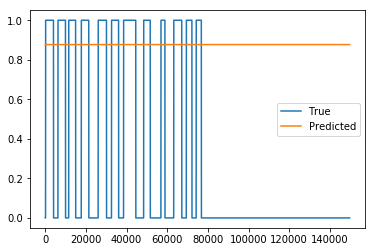

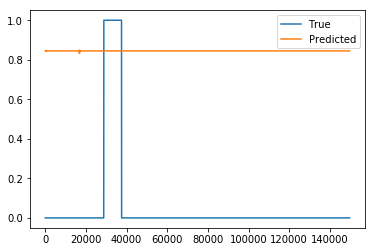

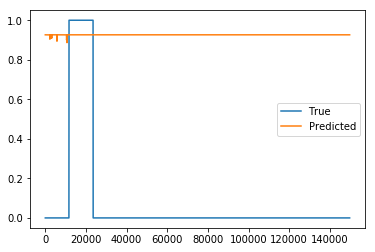

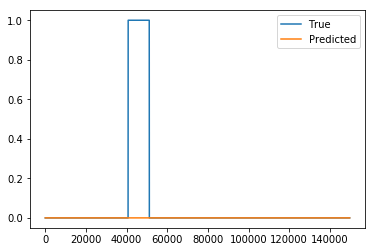

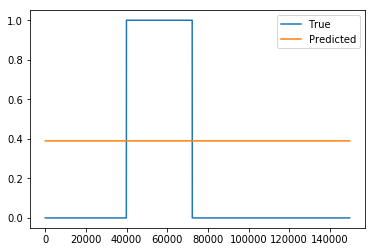

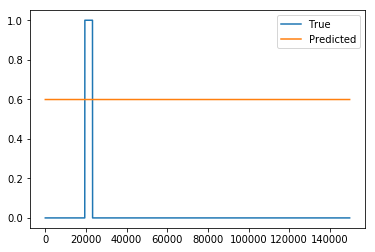

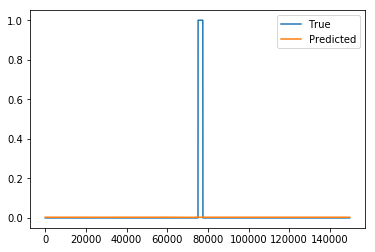

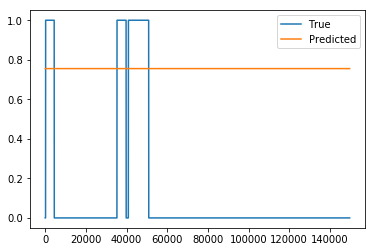

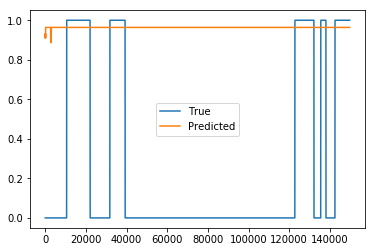

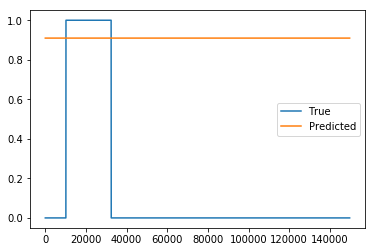

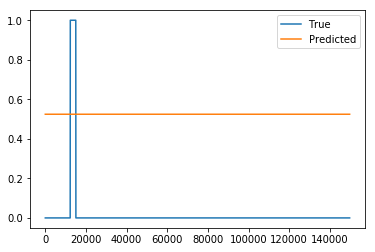

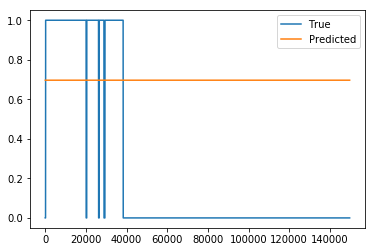

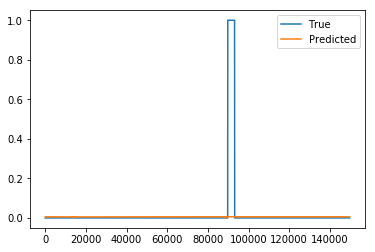

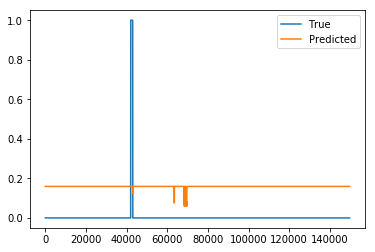

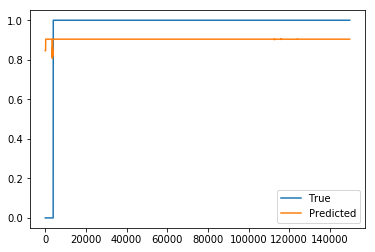

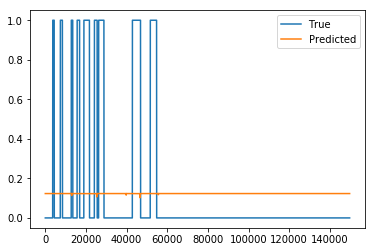

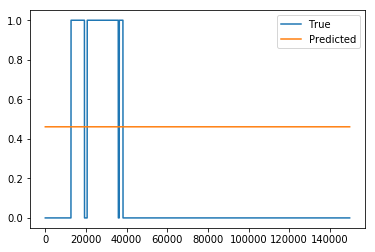

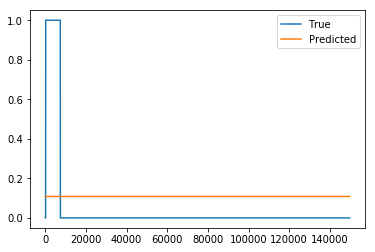

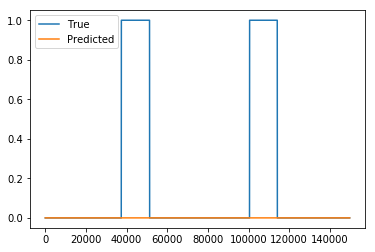

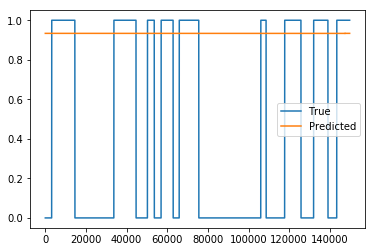

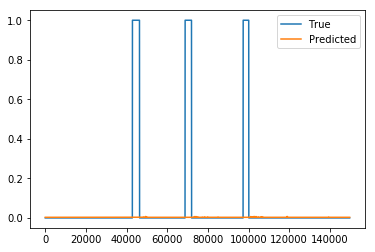

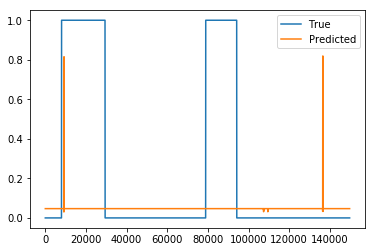

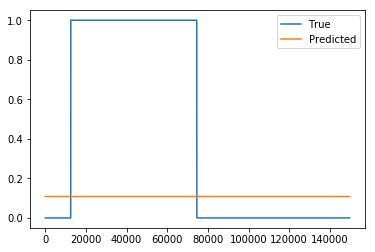

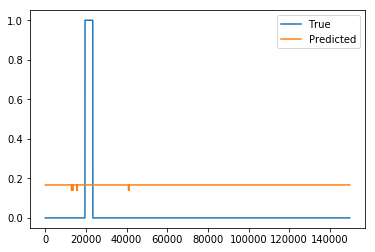

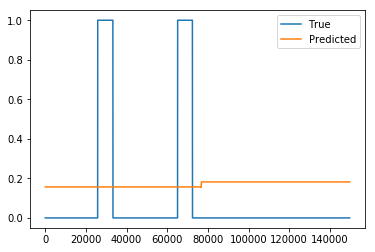

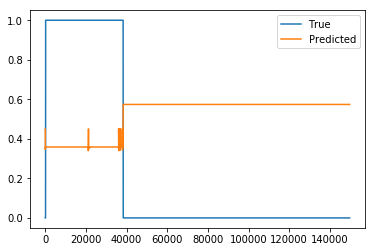

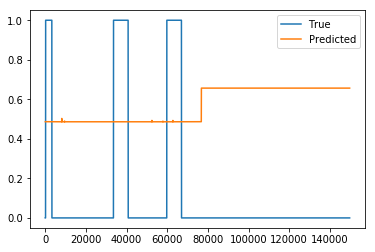

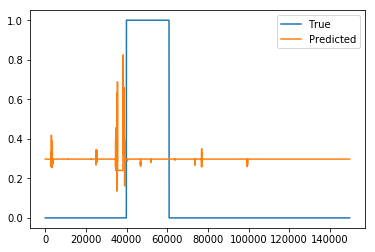

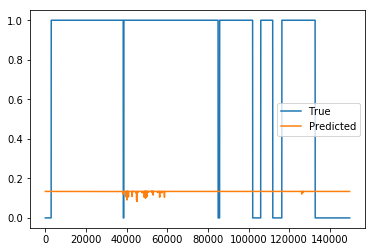

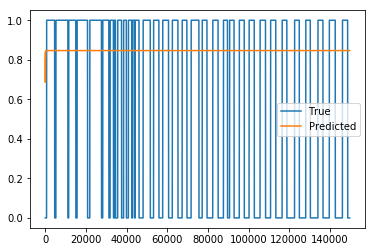

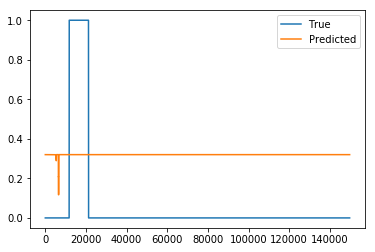

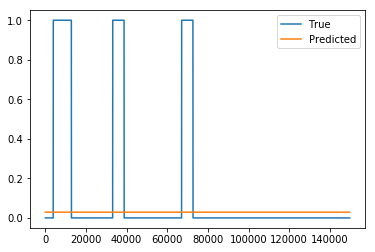

In [88]:
for series in range(32):
    true_events_line = all_true_events[:, series, :, :].reshape(-1)
    predicted_events_line = all_predicted_events[:, series, :, :].reshape(-1)
    smoothed_events_line = (moving_average(predicted_events_line, n=min_seizure_duration) > 0.3).astype(int)
    plt.plot(true_events_line, label="True")
    plt.plot(predicted_events_line, label="Predicted")
#     plt.plot(smoothed_events_line, label="Smoothed")
    plt.legend()
    plt.show()

# Seq2seq

In [ ]:
feature_extractor = eeg_input

for cnn_filters in CNN_FILTERS:
    feature_extractor = keras.layers.Conv1D(cnn_filters, kernel_size=3, padding="same", activation="relu")(feature_extractor)
    feature_extractor = keras.layers.Conv1D(cnn_filters, kernel_size=3, padding="same", activation="relu")(feature_extractor)
    feature_extractor = keras.layers.MaxPool1D(pool_size=2, padding="same")(feature_extractor)

In [ ]:
encoder_outputs, encoder_h_state, encoder_c_state = keras.layers.LSTM(RNN_SIZE, stateful=True, return_state=True)(feature_extractor)

events_input = keras.layers.Input(batch_shape=(BATCH_SIZE, CHUNK_TIME, 1), name="events")

decoder_outputs, _, _ = keras.layers.LSTM(RNN_SIZE, return_sequences=True, return_state=True)(
    events_input, 
    initial_state=[encoder_h_state, encoder_c_state]
)
decoder_outputs = keras.layers.Dense(1, activation='sigmoid')(decoder_outputs)

model = keras.models.Model(inputs=[eeg_input, events_input], outputs=[decoder_outputs])